In [1]:
%load_ext autoreload
import sys
import gc
import numpy as np 
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pickle


filename = r"C:\Users\ecsadmin\Downloads\1.pkl"
with open(filename, "rb") as f:
    dat1 = pickle.load(f)

filename = r"C:\Users\ecsadmin\Downloads\0.pkl"
with open(filename, "rb") as f:
    dat0 = pickle.load(f)

In [2]:
print(dat1.keys())

dict_keys(['n_r_branch=q1_c0', 'n_q_branch=q1_c0', 'n_r_branch=q1_c1', 'n_q_branch=q1_c1', 'n_r_branch=q1_c2', 'n_q_branch=q1_c2', 'n_r_branch=q1_c3', 'n_q_branch=q1_c3', 'n_r_branch=q1_c4', 'n_q_branch=q1_c4', 'n_r_branch=q1_c5', 'n_q_branch=q1_c5'])


In [3]:
key_list0 = ['n_q_branch=q0_c0', 'n_q_branch=q0_c1', 'n_q_branch=q0_c2', 'n_q_branch=q0_c3']
name_list0 = [r'$⟨n_c⟩ = 0$', r'$⟨n_c⟩ = 1$', r'$⟨n_c⟩ = 2$', r'$⟨n_c⟩ = 3$']
key_list1 = ['n_q_branch=q1_c0', 'n_q_branch=q1_c1', 'n_q_branch=q1_c2', 'n_q_branch=q1_c3']

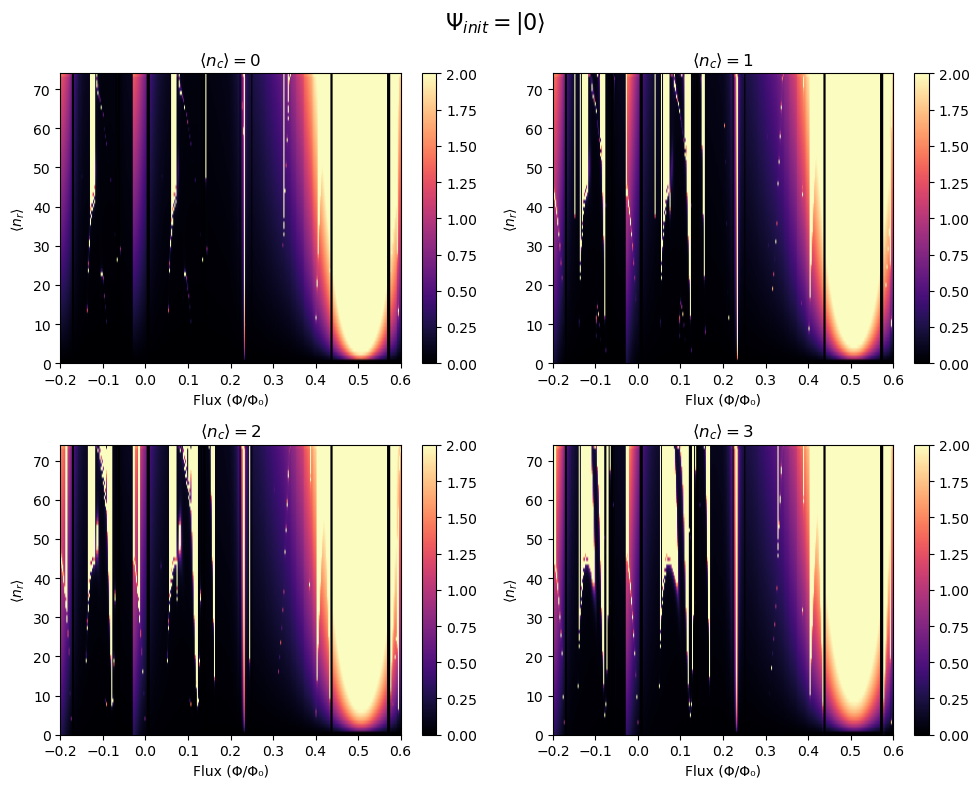

In [4]:
step =.02
flux_arr = np.arange(-.2, .6, step)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
n_r_list = np.arange(0, 75, 1)
extent = [-.2, .6, n_r_list[0], n_r_list[-1]]

for ax, key, name in zip(axes, key_list0, name_list0):
    #ax.imshow(dat0[key].T, extent=extent, cmap='magma')
    ax.set_title(name)
    ax.set_xlabel('Flux (Φ/Φ₀)')
    ax.set_ylabel(r'$⟨n_r⟩$')
    fixed = Z_fixed = np.flipud(dat0[key].T)

    im = ax.imshow(fixed, extent=extent, cmap='magma', vmin=0, vmax=2)
    ax.set_aspect("auto")

    plt.colorbar(im, ax = ax)

title = r'$\Psi_{init} = |0⟩$'
fig.suptitle(title, fontsize=16)
plt.tight_layout()
plt.savefig(r'Ground State')

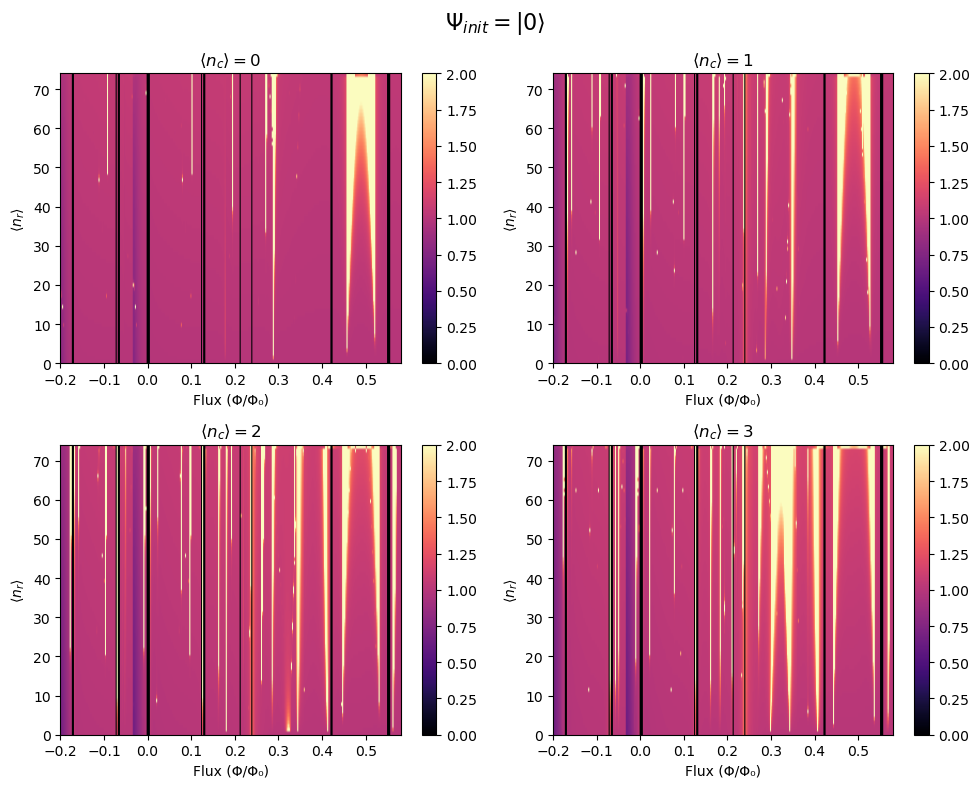

In [5]:
step =.02
flux_arr = np.arange(-.2, .6, step)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
n_r_list = np.arange(0, 75, 1)
extent = [flux_arr[0], flux_arr[-1], n_r_list[0], n_r_list[-1]]

for ax, key, name in zip(axes, key_list1, name_list0):
    #ax.imshow(dat0[key].T, extent=extent, cmap='magma')
    ax.set_title(name)
    ax.set_xlabel('Flux (Φ/Φ₀)')
    ax.set_ylabel(r'$⟨n_r⟩$')
    fixed = Z_fixed = np.flipud(dat1[key].T)

    im = ax.imshow(fixed, extent=extent, cmap='magma', vmin=0, vmax=2)
    ax.set_aspect("auto")

    plt.colorbar(im, ax = ax)

title = r'$\Psi_{init} = |0⟩$'
fig.suptitle(title, fontsize=16)
plt.tight_layout()
plt.savefig(r'Ground State')

In [49]:
def get_weights(num, omega, temp):
    omega_list = omega * np.arange(1, num+1, 1)
    temp_GHz = temp * 20.83
    propto = np.exp(-omega_list / temp_GHz)
    return propto / np.sum(propto)

In [50]:
weights = get_weights(6, 1.5, .04)

In [52]:
small0 = [key for key in dat0.keys() if ('n_q') in key]
small1 = [key for key in dat1.keys() if ('n_q') in key]

In [53]:
therm0 = sum(weight * dat0[key] for weight, key in zip(weights, small0))  
therm1 = sum(weight * dat1[key] for weight, key in zip(weights, small1))  

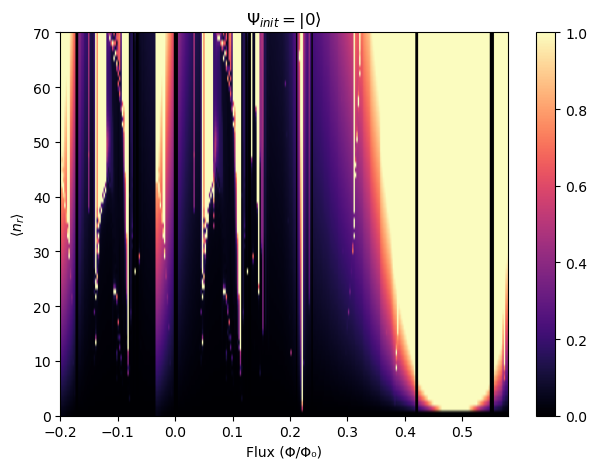

In [58]:
fixed = Z_fixed = np.flipud(therm0.T)
plt.imshow(fixed, extent=extent, cmap='magma', vmin=0, vmax=1, aspect='auto')
plt.xlabel('Flux (Φ/Φ₀)')
plt.ylabel(r'$⟨n_r⟩$')
plt.ylim(0, 70)
plt.colorbar()
#ax.set_aspect("auto")
plt.title(r'$\Psi_{init} = |0⟩$')
fig.suptitle(title, fontsize=16)
plt.tight_layout()

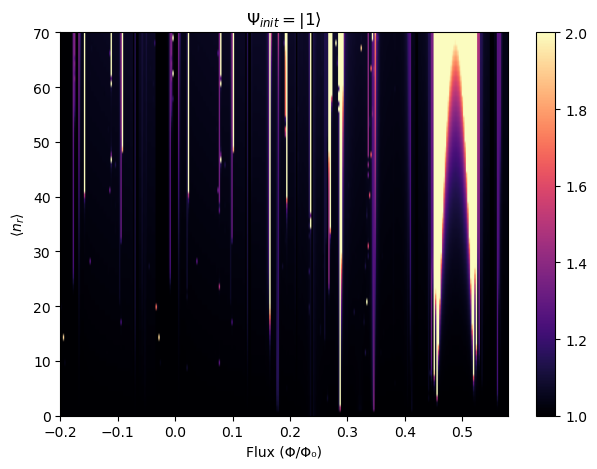

In [59]:
fixed = Z_fixed = np.flipud(therm1.T)
plt.imshow(fixed, extent=extent, cmap='magma', vmin=1, vmax=2, aspect='auto')
plt.xlabel('Flux (Φ/Φ₀)')
plt.ylabel(r'$⟨n_r⟩$')
plt.ylim(0, 70)
plt.colorbar()
#ax.set_aspect("auto")
plt.title(r'$\Psi_{init} = |1⟩$')
fig.suptitle(title, fontsize=16)
plt.tight_layout()